In [38]:
from __future__ import print_function
from zipfile import ZipFile

import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import cv2
from datetime import datetime
from sklearn.model_selection import train_test_split

In [103]:
##load your data here

class DataLoader(object):
    def __init__(self):
        DIR = '../data/'
        pass
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load_data(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = '../data/' + label_filename + '.zip'
        image_zip = '../data/' + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels

    def create_batches(self):
        pass

In [121]:
images_train , labels_train = DataLoader().load_data("train")
images_test , labels_test = DataLoader().load_data("test")  
X_train, X_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=0.30, random_state=42)


batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
train_data = []
for index,data in enumerate(X_train):
    temp = y_train[index]
    train_data.append((data,temp))
    
val_data = []
for index,data in enumerate(X_val):
    temp = y_val[index]
    val_data.append((data,temp))
    
test_data = []
for index,data in enumerate(images_test):
    temp = labels_test[index]
    test_data.append((data,temp))
    
train_data  = mx.gluon.data.DataLoader(train_data, batch_size,shuffle = True)
val_data = mx.gluon.data.DataLoader(val_data, batch_size,shuffle = False)
test_data = mx.gluon.data.DataLoader(test_data, batch_size,shuffle = False)

In [105]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

In [106]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

In [107]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        cumulative_loss = 0
        data, label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        loss = softmax_cross_entropy(output, label)
        cumulative_loss += nd.sum(loss).asscalar()
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1], cumulative_loss

In [108]:
def evaluate_accuracy_train(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data, label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [109]:
class MLP(gluon.Block):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        with self.name_scope():
            self.dense0 = gluon.nn.Dense(512)
            self.dense1 = gluon.nn.Dense(128)
            self.dense2 = gluon.nn.Dense(64)
            self.dense3 = gluon.nn.Dense(32)
            self.dense4 = gluon.nn.Dense(16)

    def forward(self, x):
        x = nd.relu(self.dense0(x))
        x = nd.relu(self.dense1(x))
        x = nd.relu(self.dense2(x))
        x = nd.relu(self.dense3(x))
        x = self.dense4(x)
        return x

In [136]:
net = MLP()
net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})
epochs = 10
smoothing_constant = .01

In [137]:
network_1_train_loss = []
network_1_valid_loss = []

In [139]:
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy_train(train_data, net)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_1_train_loss.append(cumulative_loss/num_examples)
    network_1_valid_loss.append(v_loss/num_examples)
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %
          (e, cumulative_loss/num_examples, train_accuracy, val_accuracy, v_loss/num_examples, difference))

Epoch 0. Loss: 0.45978637121915816, Train_acc 0.8242619047619048, Valid_acc 0.8182777777777778, Valid_Loss 0.0001321105400721232, Time For Epoch(in secs) 12.090284
Epoch 1. Loss: 0.3194169504165649, Train_acc 0.8393333333333334, Valid_acc 0.8361111111111111, Valid_Loss 0.00015681910514831542, Time For Epoch(in secs) 17.780693
Epoch 2. Loss: 0.2932974465529124, Train_acc 0.8498571428571429, Valid_acc 0.8456111111111111, Valid_Loss 6.898427804311116e-05, Time For Epoch(in secs) 20.503836
Epoch 3. Loss: 0.27346461867491406, Train_acc 0.8711428571428571, Valid_acc 0.8621111111111112, Valid_Loss 8.938953876495361e-05, Time For Epoch(in secs) 21.002641
Epoch 4. Loss: 0.26961541442871095, Train_acc 0.8740476190476191, Valid_acc 0.8632222222222222, Valid_Loss 9.53135093053182e-05, Time For Epoch(in secs) 20.827708
Epoch 5. Loss: 0.25301874960859616, Train_acc 0.8727142857142857, Valid_acc 0.8627222222222222, Valid_Loss 0.00015815919240315756, Time For Epoch(in secs) 23.545171
Epoch 6. Loss: 0.

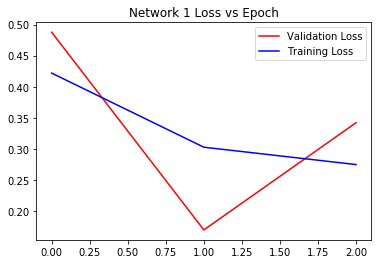

In [131]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_1_valid_loss =  [float(i)/sum(network_1_valid_loss) for i in network_1_valid_loss]
network_1_train_loss =  [float(i)/sum(network_1_train_loss) for i in network_1_train_loss]
plt.plot(network_1_valid_loss, c="red", label="Validation Loss")
plt.plot(network_1_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [115]:
network_1_valid_loss

[0.00020573606491088866, 7.178879578908285e-05, 0.00014443669319152833]

In [92]:
print ('Saving')
net.save_parameters("NN1.params")
print ('Saved')

Saving
Saved


In [133]:
net1 = MLP()
net1.load_parameters("NN1.params")
net1.collect_params()

mlp23_ (
  Parameter mlp23_dense0_weight (shape=(512, 784), dtype=float32)
  Parameter mlp23_dense0_bias (shape=(512,), dtype=float32)
  Parameter mlp23_dense1_weight (shape=(128, 512), dtype=float32)
  Parameter mlp23_dense1_bias (shape=(128,), dtype=float32)
  Parameter mlp23_dense2_weight (shape=(64, 128), dtype=float32)
  Parameter mlp23_dense2_bias (shape=(64,), dtype=float32)
  Parameter mlp23_dense3_weight (shape=(32, 64), dtype=float32)
  Parameter mlp23_dense3_bias (shape=(32,), dtype=float32)
  Parameter mlp23_dense4_weight (shape=(16, 32), dtype=float32)
  Parameter mlp23_dense4_bias (shape=(16,), dtype=float32)
)

In [134]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net1(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8589769108280255
